# Домашнее задание
Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

## Цель:
В этом проекте вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без, а также придумывать новые признаки для улучшения качества модели.


## Описание/Пошаговая инструкция выполнения домашнего задания:
### Часть 1. EDA


Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
Пройдите по основным шагам работы с данными:
выкиньте ненужные признаки: id, name, host_id, host_name, last_review
визуализируйте базовые статистики данных: распределения признаков, матрицу попарных корреляций, постройте pair plots
по результатам анализа произведите предобработку переменных

### Часть 2. Preprocessing & Feature Engineering


Ваша цель — получить как можно более высокие метрики качества (можно взять несколько, R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.


Опробуйте различные техники:

работа с категориальными переменными (можно начать с dummy);
замена аномалий;
различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler и т. д.);
обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать;

Попробуйте на основании имеющихся переменных создать новые, которые могли бы улучшить качество модели. Например, можно найти координаты Манхэттена (самого дорогого района) и при помощи широты и долготы, а также евклидова расстояния создать новую переменную — расстояние от квартиры до этого района. Возможно, такой признак будет работать лучше, чем просто широта и долгота.


### Часть 3. Моделирование


Отложите 30% данных для тестирования.
Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.
Измерьте качество каждой и визуализируйте важность признаков.
Сделайте интересные выводы :)

## В ноутбуке желательно видеть:

Понятное описание: какие техники и алгоритмы были опробованы — было бы неплохо в самом начале тезисно выписать опробованные методики и их результат (помогло / не помогло).
Наличие визуализаций (не обязательно строить много графиков — можно несколько репрезентативных).
Наличие хотя бы одной модификации данных, приводящей к улучшению результатов.

## Критерии оценки:
Домашнее задание принимается, если выполнены следующие действия:

EDA.
Базовая предобработка и построенные модели с оценкой качества.
Дополнительная генерация признаков и проверка качества моделей с ними.

# Решение

## EDA

### Загрузка данных

In [1]:
import pandas as pd

df = pd.read_csv("AB_NYC_2019.csv")
df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Удаление лишнего

In [2]:
df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], inplace=True)


### Базовая статистика и визуализации

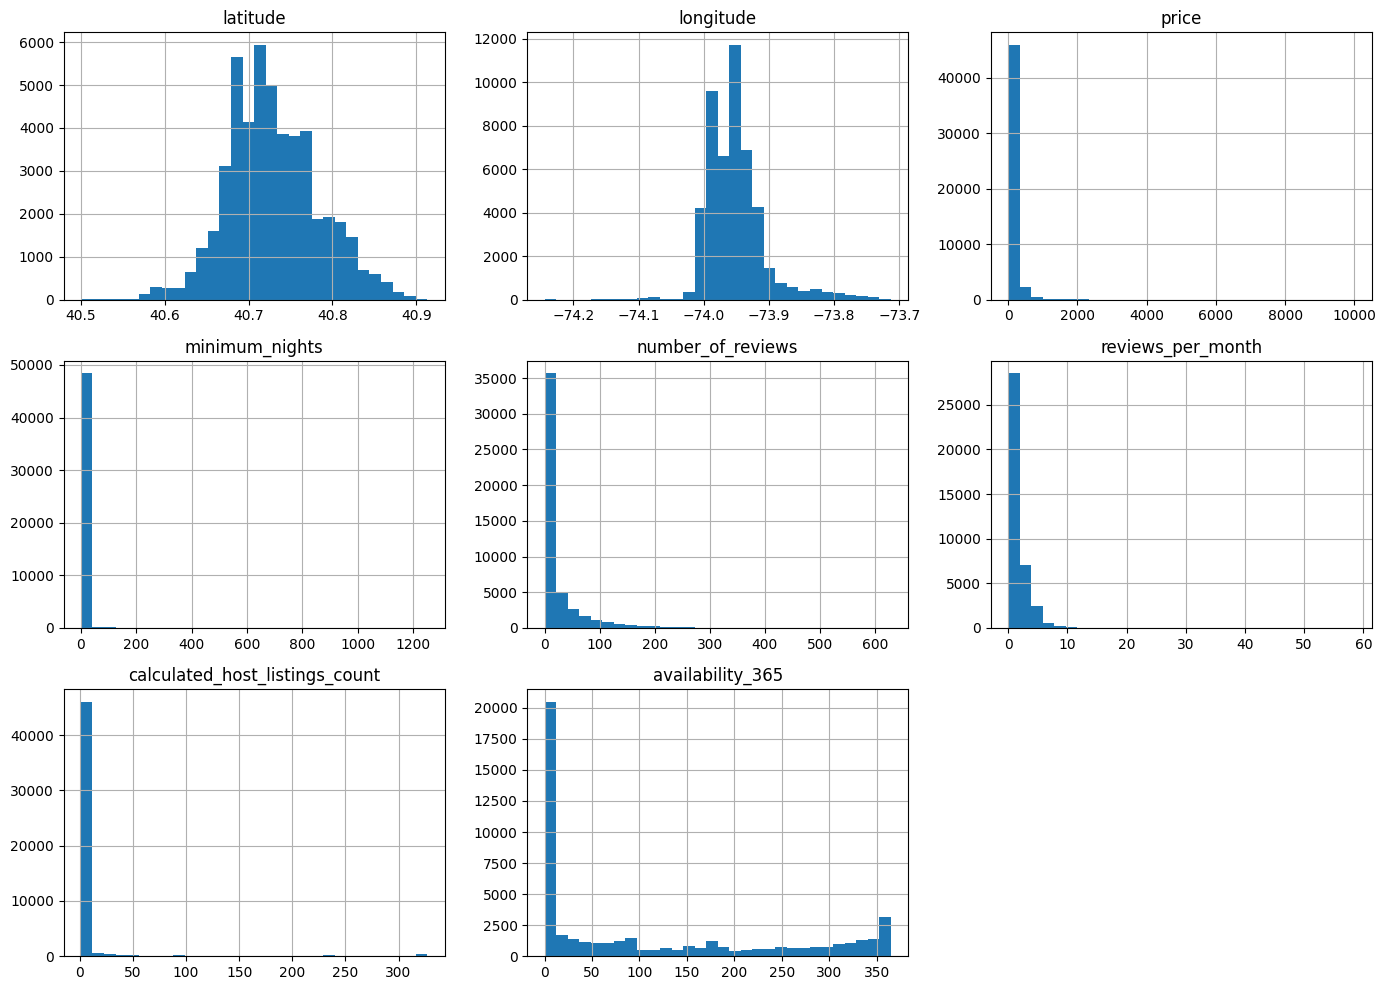

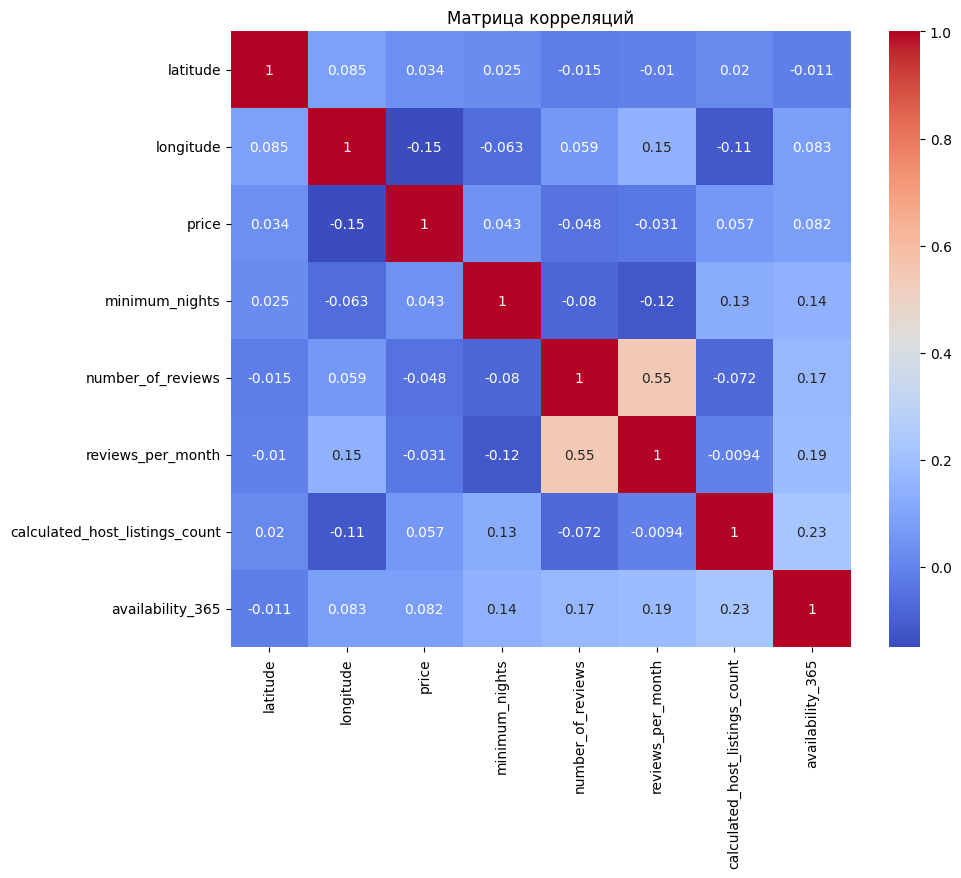

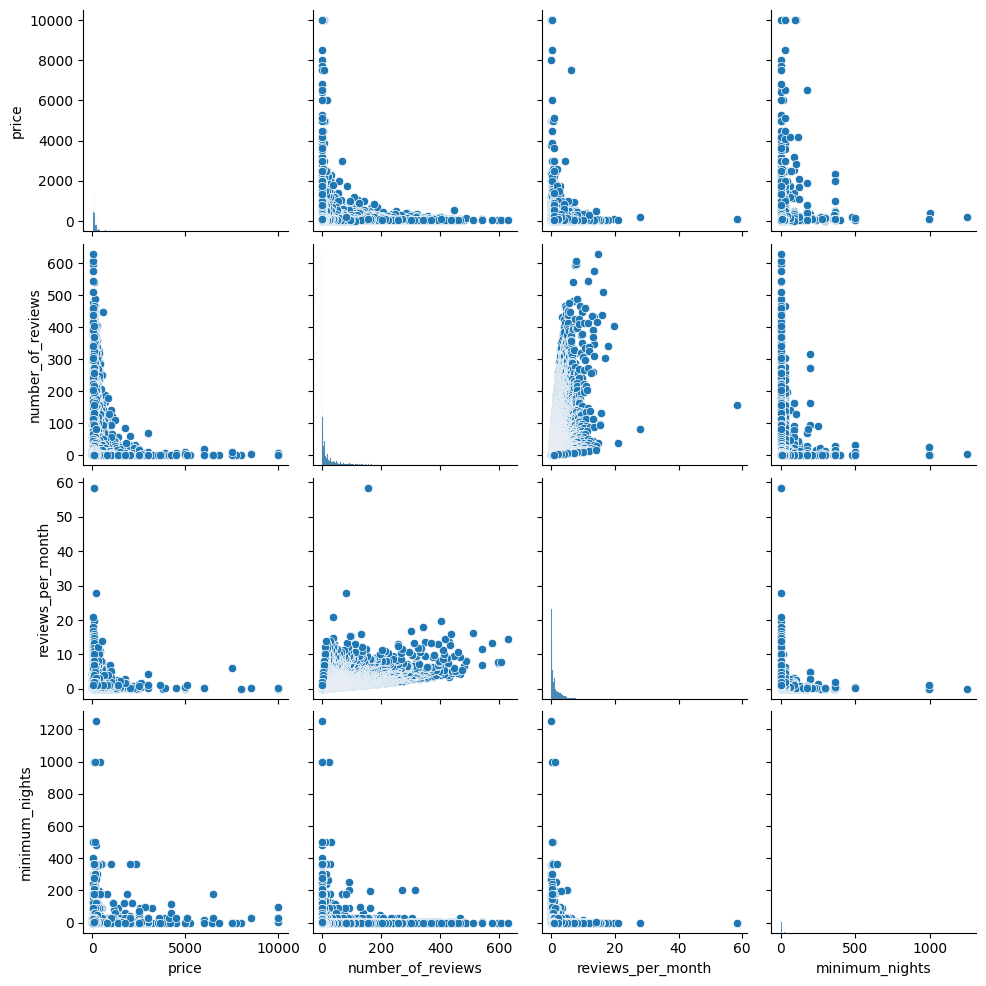

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df.describe()

# Гистограммы
df.hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()

# Корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Матрица корреляций")
plt.show()

# Pairplot
sns.pairplot(df[['price', 'number_of_reviews', 'reviews_per_month', 'minimum_nights']])


## Preprocessing & Feature Engineering

### Обработка категориальных переменных

In [4]:
df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'], drop_first=True)


### Обработка выбросов

In [5]:
# Уберем нулевые и аномально высокие цены
df = df[(df['price'] > 0) & (df['price'] < 1000)]

# Ограничим минимальное число ночей
df = df[df['minimum_nights'] < 365]


### Масштабирование признаков

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

df[num_cols] = scaler.fit_transform(df[num_cols])


### Признак “расстояние до Манхэттена”

In [7]:
# Координаты условного центра Манхэттена
manhattan_lat, manhattan_lon = 40.7831, -73.9712

df['distance_to_manhattan'] = ((df['latitude'] - manhattan_lat)**2 + (df['longitude'] - manhattan_lon)**2) ** 0.5


## Моделирование

### Train/Test Split

In [8]:
print(df.columns)


Index(['neighbourhood', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'room_type_Private room', 'room_type_Shared room',
       'distance_to_manhattan'],
      dtype='object')


In [9]:
# Удаляем нечисловые признаки
X = df.drop(columns=['price', 'neighbourhood'])

# Удаляем или заполняем NaN
X = X.fillna(0)  

# Преобразуем категориальные признаки
X = pd.get_dummies(X, drop_first=True)



In [10]:
from sklearn.model_selection import train_test_split

y = df['price']
X = df.drop(columns='price')
X = X.fillna(0)
X = pd.get_dummies(X, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [11]:
X_train.values 

array([[-0.3304654044938025, -0.9683234715076903, -0.4040834000455738,
        ..., False, False, False],
       [-1.5232144118089197, -0.47266411136591807, -0.2595698340024228,
        ..., False, False, False],
       [-1.5966848191719718, 1.0879696432072896, -0.11505626795927179,
        ..., False, False, False],
       ...,
       [0.5925867458677876, 0.03620994325566645, -0.4040834000455738,
        ..., False, False, False],
       [1.1270335744910385, -0.5008265750100571, -0.2595698340024228,
        ..., False, False, False],
       [-0.24600191872234206, -0.21378608017255585, -0.4040834000455738,
        ..., False, False, False]], dtype=object)

In [12]:
y_train.values

array([109,  57,  90, ...,  90,  99, 150])

### LinearRegression + RidgeCV + LassoCV + ElasticNetCV

In [13]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

models = {
    "Linear": LinearRegression(),
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 50)),
    "Lasso": LassoCV(cv=5),
    "ElasticNet": ElasticNetCV(cv=5)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{name}:")
    print("R2:", r2_score(y_test, preds))
    print("MAE:", mean_absolute_error(y_test, preds))
    print()

Linear:
R2: 0.3721552974805472
MAE: 53.226094598385906

Ridge:
R2: 0.3738691896961668
MAE: 53.057488721786235



/Users/alt3rmann/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74658.69563809037, tolerance: 34508.30187771648
  model = cd_fast.enet_coordinate_descent_gram(
/Users/alt3rmann/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124467.97378456593, tolerance: 34508.30187771648
  model = cd_fast.enet_coordinate_descent_gram(


Lasso:
R2: 0.3721343279352387
MAE: 53.06337941534252

ElasticNet:
R2: 0.3390399809233646
MAE: 54.68400779584317



### Визуализация важности признаков

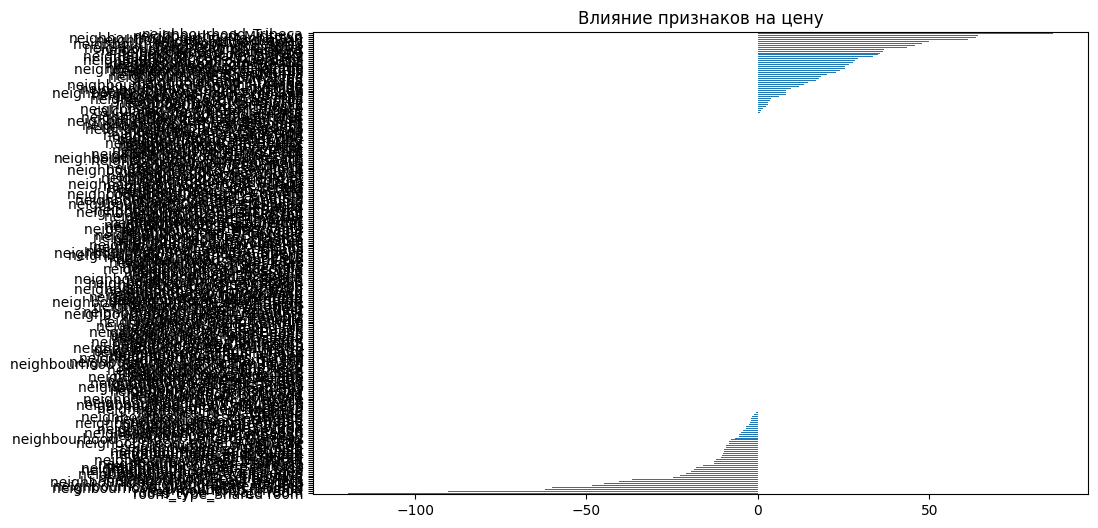

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

best_model = models["Lasso"]  # или выбери другую модель
coefs = pd.Series(best_model.coef_, index=X.columns)

plt.figure(figsize=(10, 6))
coefs.sort_values().plot(kind='barh')
plt.title("Влияние признаков на цену")
plt.show()
